In [1]:
% load_ext rpy2.ipython

In [2]:
%%R
library("phyloseq")
library(ggplot2)
library(stringr)
library(dplyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [15]:
%%R
physeq = import_biom("../../SeqData/otu_table.tax.meta.biom", "../../SeqData/trees/fulltree.tre", parseFunction = parse_taxonomy_greengenes)

Merge<-paste(as.character(sample_data(physeq)$Trtmt),as.character(sample_data(physeq)$Month),as.character(sample_data(physeq)$Cosm),sep="_")
sample_data(physeq)$Merge <- Merge
# Creating a new column in the phyloseq sample data called Merge,
# which contains a concatenated ID so all samples from the same mineral, month, and cosm
# will have the same ID (thus merging PCR and buffer replicates).

ps.merged = merge_samples(physeq, "Merge")
# Merging the phyloseq object by biological replicates

keep=c("Cosm","Month","Trtmt")
sd = sample_data(ps.merged)
sd = sd[,keep]
sd$Trtmt = substring(row.names(sd),1,1)
sd$Trtmt[sd$Trtmt=="B"]="Blank"
sd$Trtmt[sd$Trtmt=="F"]="Ferrihydrite"
sd$Trtmt[sd$Trtmt=="Q"]="Quartz"
sd$Trtmt[sd$Trtmt=="H"]="Heavy Fraction"
sd$Trtmt[sd$Trtmt=="S"]="Soil"
sd$Trtmt[sd$Trtmt=="K"]="Kaolinite"
sample_data(ps.merged) = sd
physeq = ps.merged

In [19]:
%%R
physeq = prune_samples(sample_sums(physeq)>1000, physeq)
otu_table(physeq) = transform_sample_counts(physeq, function(x) x / sum(x))

In [20]:
%%R
dist = distance(physeq, method="unifrac", weighted=TRUE)
# Okay, I have created the distance matrix.
# Now I want to compare the distance between my mineral samples and the soil samples

In [21]:
%%R
dist = as.matrix(dist)
dim(dist)

[1] 59 59


In [22]:
%%R
head(dist)

               B__    F_2_15    F_2_28    F_2_33     F_2_9  F_2.5_13  F_2.5_14
B__      0.0000000 0.5009606 0.4105237 0.4287829 0.3909263 0.4278323 0.4220774
F_2_15   0.5009606 0.0000000 0.3739212 0.4283939 0.4367688 0.4120369 0.3316003
F_2_28   0.4105237 0.3739212 0.0000000 0.2390091 0.2534798 0.1422454 0.2717199
F_2_33   0.4287829 0.4283939 0.2390091 0.0000000 0.2576486 0.2083234 0.2845484
F_2_9    0.3909263 0.4367688 0.2534798 0.2576486 0.0000000 0.2820581 0.3005266
F_2.5_13 0.4278323 0.4120369 0.1422454 0.2083234 0.2820581 0.0000000 0.2485719
          F_2.5_16  F_2.5_27   F_2.5_3  F_2.5_30  F_2.5_31  F_2.5_42  F_2.5_49
B__      0.4136825 0.3854794 0.3527610 0.3906395 0.3736092 0.3682081 0.3869899
F_2_15   0.2635842 0.3605375 0.4147039 0.4305680 0.4312795 0.4459164 0.4511424
F_2_28   0.2774702 0.2466602 0.2478583 0.2591283 0.2862689 0.2722851 0.3204906
F_2_33   0.3321845 0.2944864 0.2625999 0.2109872 0.2637485 0.2801706 0.3376013
F_2_9    0.2798902 0.2511078 0.2034484 0.1524322 0.1

In [7]:
%%R
#dist = as.matrix(dist)
#dist = dist[38:51,1:37]
#dist = dist[43:57,1:42]
# Needs to be adjusted depending on physeq pruning.

# This gives me the distance matrix of soil distance to each mineral.
# Now I want to group together all those where the microcosms are the same
# I can take each column, pull out the distance of this mineral to those soil samples
# Then, I need to get the cosm ID from each soil sample
# And I need to collect the cosm ID from the mineral sample
# My end goal is a table with the date, the mineral treatment, distance to a soil value, 
# and whether that distance is from the same cosm
# Month - Trtmt - Dist - SameCosm
# Then run ANOVA testing Dist ~ SameCosm + Trtmt + Month, etc.


NULL


In [34]:
%%R
Distance_summary = function(dist){
        total.info = data.frame(MTrtmt=factor(),STrtmt=factor(),MMonth=factor(),SMonth=factor(),MCosm=factor(),SCosm=factor(),Dist=numeric())
        samples <- colnames(dist)
        soils <- rownames(dist)
        SameCosm = c()
#        SCosm = character()
#        MCosm = character()
    
        for (i in samples) {
            name = paste(i)
            MTrtmt = str_extract(name,"[A-Z]?")
            MMonth = str_extract(name,"[0-9]+[.]?[0-9]?")
            MCosm = str_extract(substring(name,nchar(name)-1,nchar(name)),"[0-9]{1,2}")
            sample.info = data.frame(MTrtmt=factor(),STrtmt=factor(),MMonth=factor(),SMonth=factor(),MCosm=factor(),SCosm=factor(),Dist=numeric(),SameCosm=numeric())
            for (j in soils) {
                sname = paste(j)
                STrtmt = str_extract(sname,"[A-Z]?")
                SMonth = str_extract(sname,"[0-9]+[.]?[0-9]?")
                SCosm = str_extract(substring(sname,nchar(sname)-1,nchar(sname)),"[0-9]{1,2}")
                Dist = dist[i,j]
                distance.df = data.frame(MTrtmt,STrtmt,MMonth,SMonth,MCosm,SCosm,Dist)
                sample.info = rbind(sample.info,distance.df)
            }
            total.info = rbind(total.info,sample.info)
        }
    return(total.info)
}
# Extracts the distances for each sample with their sample data

In [35]:
%%R
dist.summ<-Distance_summary(dist)
dim(dist.summ)

[1] 3481    7


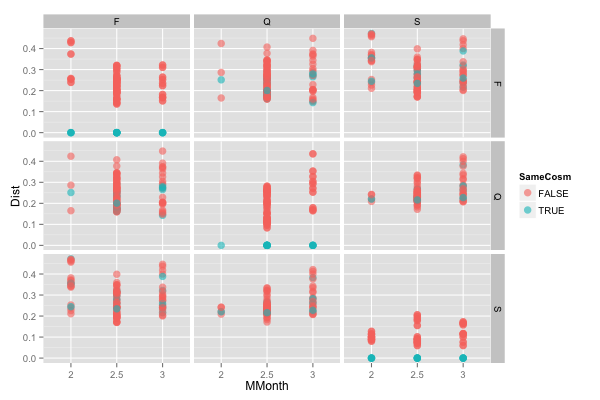

In [38]:
%%R -w 600 -h 400

d = dist.summ %>%
    group_by(STrtmt,MTrtmt,SMonth,MMonth)%>%
    filter(SMonth==MMonth)%>%
    filter(STrtmt=="F"|STrtmt=="Q"|STrtmt=="S")%>%
    filter(MTrtmt=="F"|MTrtmt=="Q"|MTrtmt=="S")

d$SameCosm = c(d$SCosm==d$MCosm)

p = ggplot(d, aes(x=MMonth, y=Dist, colour=SameCosm))
p = p  + geom_point(size=3.5, alpha=0.6)
p = p + facet_grid(~MTrtmt~STrtmt)
p
# Here we can see if the samples become more self-similar over time
# Soils are the most similar, F may be less self-similar than quartz

In [11]:
%%R

d = dist.summ %>%
    group_by(STrtmt,MTrtmt,SMonth,MMonth)%>%
    filter(SMonth==MMonth)%>%
    filter(STrtmt=="F"|STrtmt=="Q"|STrtmt=="S")%>%
    filter(MTrtmt=="F"|MTrtmt=="Q"|MTrtmt=="S")

dist.aov = aov(data=d, Dist~MMonth+MTrtmt+MMonth*MTrtmt)
summary(dist.aov)

Error in eval(expr, envir, enclos) : object 'dist.summ' not found


There is not a clear effect of the specific soil on the mineral samples